## NLP project

Read all data

In [184]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/Colab Notebooks/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
train_data = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
dev_data = pd.read_csv('dev.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
test_data = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])

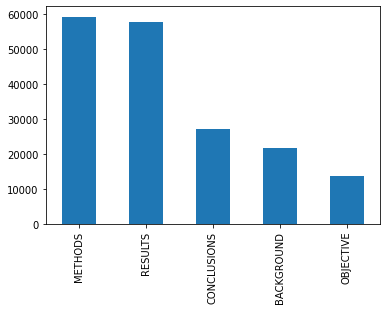

In [4]:
train_data['label'].value_counts().plot(kind='bar')

In [5]:
import spacy
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load('en_core_web_sm')

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
# Cleaning process such that replacing punctuation to space, deleting them, or making them lowercase

def clean_text(text):
    
    punctuation = [i for i in ',./\\;:\'@#~[{]}=+-_)(*&^%$£"!`)]']
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.replace("'s", "")
    text = "".join([" " if t in punctuation else t for t in text]).lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

def split_training_set(X_train, y_train):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)
    for first_index, second_index in skf.split(X_train, y_train):
        X_train_f, X_train_s = X_train[first_index], X_train[second_index]
        y_train_f, y_train_s = y_train[first_index], y_train[second_index]
        
    return X_train_f, y_train_f, X_train_s, y_train_s

def evaluate(y_true, y_pred):
    y_true = le.inverse_transform(y_true)
    y_pred = le.inverse_transform(y_pred)
    print(classification_report(y_true, y_pred))

### Which vectorizer is the best? Tf-idf vs Bag of words
This section aims to find out the best vectorizer that makes the first two machine learning models having better performance with respect to F1-score


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [8]:
%%time

train_text_cleaned = train_data['txt'].apply(clean_text)
devel_text_cleaned = dev_data['txt'].apply(clean_text)
test_text_cleaned = test_data['txt'].apply(clean_text)


CPU times: user 48.1 s, sys: 2.64 s, total: 50.7 s
Wall time: 54.7 s


In [9]:
le = LabelEncoder()
y_train = le.fit_transform(train_data['label'])
y_devel = le.transform(dev_data['label'])
y_test = le.transform(test_data['label'])

cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cw_dict = dict(zip(np.unique(y_train), cw))
cw_dict

{0: 1.657292769365306,
 1: 1.3253828032979977,
 2: 0.6066753154853166,
 3: 2.6019221041982803,
 4: 0.6213310786326851}

In [ ]:
bow_vec = CountVectorizer(tokenizer=word_tokenize)
tfidf = TfidfVectorizer(tokenizer=word_tokenize)

random_seed = 42

bow_pipeline = Pipeline([
    ('bow', bow_vec),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

tfidf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])

print('-------Bag of word result----------')
bow_pipeline.fit(train_text_cleaned, y_train)
y_pred = bow_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

print('-------TFIDF result----------')
tfidf_pipeline.fit(train_text_cleaned, y_train)
y_pred = tfidf_pipeline.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

-------Bag of word result----------
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.58      0.55      3449
 CONCLUSIONS       0.65      0.68      0.67      4582
     METHODS       0.86      0.85      0.85      9964
   OBJECTIVE       0.50      0.55      0.53      2376
     RESULTS       0.88      0.82      0.84      9841

    accuracy                           0.76     30212
   macro avg       0.68      0.69      0.69     30212
weighted avg       0.77      0.76      0.76     30212

-------TFIDF result----------
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.60      0.57      3449
 CONCLUSIONS       0.65      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.80      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.70      0.72      0.70     30212
weighted av

From the experiment, we noticed that TFIDF vectorizer is bit more effective to improve LR's performance.

Next, we need to discover the sufficient ngram range for TF-IDF vectorizer to have the best performance. This stage also considers the computational time for each ngram size simultaneously. 

*Result*
bigram and trigram show better performance than unigram. However, for trigram, it takes about 5minutes compared to 11 sec for unigram

ngram_range=(1,2) is reasonable to get feasible running time and better performance

In [ ]:
import time

ngram_candidates = [(1,1), (1,2), (1,3)]

for ngram in ngram_candidates:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram)),
        ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
    ])
    tick = time.time()
    pipeline.fit(train_text_cleaned, y_train)
    tock = time.time()
    print('Time elapsed:', tock-tick)
    y_pred = pipeline.predict(devel_text_cleaned)
    evaluate(y_devel, y_pred)

Time elapsed: 21.688993215560913
              precision    recall  f1-score   support

  BACKGROUND       0.55      0.58      0.57      3449
 CONCLUSIONS       0.66      0.71      0.68      4582
     METHODS       0.87      0.85      0.86      9964
   OBJECTIVE       0.51      0.61      0.56      2376
     RESULTS       0.89      0.81      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.69      0.71      0.70     30212
weighted avg       0.78      0.77      0.77     30212

Time elapsed: 137.30048251152039
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.60      0.60      3449
 CONCLUSIONS       0.67      0.75      0.71      4582
     METHODS       0.87      0.87      0.87      9964
   OBJECTIVE       0.56      0.60      0.58      2376
     RESULTS       0.89      0.82      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.72      0.73      0.72     30212
weighted av

### Model1: Logistic Regression with Tf-idf vectorizer 

The first model which is the baseline model is to use logistic regression. The only given hyperparameter is balancing class weights for handling imbalanced data.

In [ ]:
ngram = (1,2)

model_1 = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ('LR', LogisticRegression(class_weight=cw_dict, random_state=random_seed, n_jobs=-1))
])
model_1.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f1d65a39b00>)),
                ('LR',
                 LogisticRegression(class_weight={0: 1.657292769365306,
                                                  1: 1.3253828032979977,
                                                  2: 0.6066753154853166,
                                                  3: 2.6019221041982803,
                                                  4: 0.6213310786326851},
                                    n_jobs=-1, random_state=42))])

In [ ]:
y_pred = model_1.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.59      0.60      0.59      3449
 CONCLUSIONS       0.65      0.75      0.70      4582
     METHODS       0.86      0.87      0.87      9964
   OBJECTIVE       0.55      0.64      0.59      2376
     RESULTS       0.90      0.80      0.85      9841

    accuracy                           0.78     30212
   macro avg       0.71      0.73      0.72     30212
weighted avg       0.79      0.78      0.78     30212



### Model2: Linear SVM with Tf-idf Vectorizer

The next model is Linear SVM with the same technique for imbalanced data. Additional hyperparameter for SVM is cost parameter which is set to 1.

In [ ]:
model_2 = Pipeline([
    ("tf-idf", TfidfVectorizer(tokenizer=word_tokenize, ngram_range=ngram)),
    ("LinearSVM", LinearSVC(class_weight=cw_dict, random_state=random_seed, C=1))
])
model_2.fit(train_text_cleaned, y_train)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function word_tokenize at 0x7f1d65a39b00>)),
                ('LinearSVM',
                 LinearSVC(C=1,
                           class_weight={0: 1.657292769365306,
                                         1: 1.3253828032979977,
                                         2: 0.6066753154853166,
                                         3: 2.6019221041982803,
                                         4: 0.6213310786326851},
                           random_state=42))])

In [ ]:
y_pred = model_2.predict(devel_text_cleaned)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.61      0.58      0.60      3449
 CONCLUSIONS       0.70      0.73      0.71      4582
     METHODS       0.85      0.91      0.88      9964
   OBJECTIVE       0.61      0.57      0.59      2376
     RESULTS       0.89      0.85      0.87      9841

    accuracy                           0.80     30212
   macro avg       0.73      0.73      0.73     30212
weighted avg       0.80      0.80      0.80     30212



### Model3: Conv1D network

#### Word Embedding layer
Prior to build word embedding layer, the texts were vectorized using `TextVectorization`. The vectors are encoded as 296 word sequence length which is the maximum length in the entire sentences in the training set. The max size of vocabulary of this vectorizer is 68,000 which is the total number of vocabulary in the training set. After vectorizing, embedding dimension is set to 150 as my machine can handle.
#### Conv1D layer
- filter_size = 64
- kernel_size = 5
- activation = ReLU
- Dropout = 0.2

#### Training setting
- epochs = 3
- batch_size = 256
- balancing class weights

Such setting follows the codes from practical session

In [11]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

sentence_len = [len(sent.split()) for sent in train_data['txt'].tolist()]
max(sentence_len)

296

In [12]:
max_tokens = 68000
seq_len = 296

text_vec = TextVectorization(max_tokens=max_tokens, 
                             pad_to_max_tokens=True, 
                             output_sequence_length=seq_len,
                             output_mode='int')
text_vec.adapt(train_text_cleaned)

In [15]:
from tensorflow.keras.utils import to_categorical, set_random_seed

random_seed = 42
embedding_dim = 150
hidden_dims=32
filter1 = 64
kernel_size=5
input_dim = len(text_vec.get_vocabulary())
set_random_seed(random_seed)
# np.set_random_seed(random_seed)

y_train_vec = to_categorical(y_train, num_classes=5, dtype=int)
y_devel_vec = to_categorical(y_devel, num_classes=5, dtype=int)
y_test_vec = to_categorical(y_test, num_classes=5, dtype=int)

# x_train = pad_sequences(train_text_cleaned, maxlen=seq_len)
# x_test = pad_sequences(devel_text_cleaned, maxlen=seq_len)

In [24]:
from keras.layers import Embedding, Dropout, Dropout, Dense, GlobalMaxPooling1D
from keras.layers import Conv1D
from sklearn.metrics import f1_score

model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(text_vec)
model.add(Embedding(input_dim=input_dim,
                    output_dim=embedding_dim,
                    mask_zero=True,
                   input_length=seq_len))
model.add(Conv1D(filter1,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Finished building model.\n')
print(model.summary())

Finished building model.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 296)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 296, 150)          8685300   
                                                                 
 conv1d_3 (Conv1D)           (None, 292, 64)           48064     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)            

In [25]:
model.fit(train_text_cleaned, y_train_vec, class_weight=cw_dict, batch_size=32, epochs=3, validation_data=(devel_text_cleaned, y_devel_vec))
# y_train_vec

Epoch 1/3
5627/5627 [==============================] - 63s 11ms/step - loss: 0.8069 - accuracy: 0.7401 - val_loss: 0.6015 - val_accuracy: 0.7844
Epoch 2/3
5627/5627 [==============================] - 66s 12ms/step - loss: 0.5743 - accuracy: 0.8240 - val_loss: 0.6388 - val_accuracy: 0.7687
Epoch 3/3
5627/5627 [==============================] - 63s 11ms/step - loss: 0.3950 - accuracy: 0.8788 - val_loss: 0.6800 - val_accuracy: 0.7737


In [26]:
y_pred_vec = model.predict(devel_text_cleaned)
y_pred = np.argmax(y_pred_vec, axis=1)
evaluate(y_devel, y_pred)

              precision    recall  f1-score   support

  BACKGROUND       0.55      0.59      0.57      3449
 CONCLUSIONS       0.66      0.71      0.69      4582
     METHODS       0.87      0.86      0.87      9964
   OBJECTIVE       0.56      0.58      0.57      2376
     RESULTS       0.88      0.82      0.85      9841

    accuracy                           0.77     30212
   macro avg       0.70      0.71      0.71     30212
weighted avg       0.78      0.77      0.78     30212



### Model4: Different embedding layer with the Conv1D network

### Model5: Model from the paper

According to the paper [(Neural Networks for Joint Sentence classification in Mecial Paper Abstracts)](https://arxiv.org/pdf/1612.05251.pdf), the suggested model outperforms other baseline models such as Logistic Regression, Forward ANN, and CRF. The last model follows the instructions at the paper.

- Additional information for the model is to label which line is the corresponding sentence in the abstract and give the total number of lines in the abstract.
This should be effective because abstracts are typically structured writing especially medical paper. Additionally, it is obvious the 'METHOD' part is followed by 'RESULT' part. Such information would be helpful for the model to classify the sentence.

In [198]:
lines = []
current = 0
count = 0
train_data['total_lines'] = 0
for i, id in enumerate(train_data['pmid']):
    if current != id:
        train_data['total_lines'][i-count:i] = count
        current = id
        count = 1
    else:
        count += 1
    lines.append(count)

train_data['total_lines'][i-count+1:] = count
train_data['line_number'] = lines
train_data

/tmp/ipykernel_46577/1246308742.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['total_lines'][i-count:i] = count
/tmp/ipykernel_46577/1246308742.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['total_lines'][i-count+1:] = count


,pmid,label,txt,line_number,total_lines
0,24293578,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,1,12
1,24293578,METHODS,A total of 125 patients with primary knee OA w...,2,12
2,24293578,METHODS,Outcome measures included pain reduction and i...,3,12
3,24293578,METHODS,Pain was assessed using the visual analog pain...,4,12
4,24293578,METHODS,Secondary outcome measures included the Wester...,5,12
...,...,...,...,...,...
180035,26227186,RESULTS,For the absolute change in percent atheroma vo...,8,12
180036,26227186,RESULTS,"For PAV , a significantly greater percentage o...",9,12
180037,26227186,RESULTS,Both strategies had acceptable side effect pro...,10,12
180038,26227186,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11,12
